In [1]:
from rdflib import Graph
from rdflib.namespace import RDF, OWL
from rdflib.term import BNode
from cmatcher.owl_utils import *
from tqdm.auto import tqdm
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import degree
from torch_geometric.loader import DataLoader
from cmatcher.cqa_search import *
from torch_geometric.nn import MessagePassing
from cmatcher.eval_utils import *
from transformers import AutoTokenizer, BertModel, DistilBertModel, AutoModel
import transformers.optimization as toptim
import dill
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import time
import copy

from cmatcher.model import *

from accelerate import Accelerator, notebook_launcher
import random
import wandb

torch.manual_seed(0)
random.seed(0)

In [ ]:
test_ont = 'cmt'

config = {
    'learning_rate': 0.00001,
    'language_model': 'bert-base-uncased',
    'architecture': 'gnn',
    'epochs': 5,
    'batch_size': 2
}

wandb.init(
    project='cmatcher',
    config=config,
    settings=wandb.Settings(_disable_stats=True, _disable_meta=True)
)

In [9]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
ontology_paths = {
    'edas.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/edas.owl',
    'ekaw.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/ekaw.owl',
    'confOf.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/confOf.owl',
    'conference.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/conference.owl',
    'cmt.owl': '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/cmt.owl',
}

cqa_path = '/projets/melodi/gsantoss/data/complex/CQAs'
entities_path = '/projets/melodi/gsantoss/data/complex/entities-cqas'

In [11]:
if os.path.exists('/projets/melodi/gsantoss/tmp/idata.pkl'):
    with open('/projets/melodi/gsantoss/tmp/idata.pkl', 'rb') as f:
        train_ont_cqa_subg = dill.load(f)
        print('loaded from cache.')
else:
    with open('/projets/melodi/gsantoss/tmp/idata.pkl', 'wb') as f:
        dill.dump(load_entities(entities_path, ontology_paths), f)

isg = load_sg(entities_path, ontology_paths)

cqas = load_cqas(cqa_path)
raw_data = build_raw_data(train_ont_cqa_subg, cqas)


loaded from cache.


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

In [13]:

if os.path.exists(f'/projets/melodi/gsantoss/tmp/{test_ont}.pkl'):
    with open(f'/projets/melodi/gsantoss/tmp/{test_ont}.pkl', 'rb') as f:
        ifd, mc, mp, fres = dill.load(f)
        print('loaded from cache.')
else:
    ifd, mc, mp, fres = build_raw_ts(f'/projets/melodi/gsantoss/data/oaei/tracks/conference/onts/{test_ont}.owl',
                                     isg[test_ont],
                                     workers=4)
    with open(f'/projets/melodi/gsantoss/tmp/{test_ont}.pkl', 'wb') as f:
        dill.dump((ifd, mc, mp, fres), f)


loaded from cache.


In [14]:
conts_cqa_subg = copy.deepcopy(train_ont_cqa_subg)
del conts_cqa_subg[test_ont]

In [12]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [15]:



root_entities, graph_data, cq, cqid, caq, cqmask, tor = prepare_eval_dataset(test_ont, cqas, ifd, tokenizer, mc, mp,
                                                                             fres, filter_bn=False)


  0%|          | 0/140 [00:00<?, ?it/s]

Launching training on 2 GPUs.


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


  0%|          | 0/416 [00:00<?, ?it/s]

First evaluation:
bt: 0.65 avgp: 0.30, rec: 0.24, afm: 0.26
ekaw bt: 0.65 avgp: 0.11, rec: 0.17, afm: 0.14
edas bt: 0.65 avgp: 0.17, rec: 0.24, afm: 0.20
confOf bt: 0.65 avgp: 0.20, rec: 0.25, afm: 0.22
conference bt: 0.65 avgp: 0.17, rec: 0.17, afm: 0.17
ev data: 0.00
bt: 0.85 avgp: 0.36, rec: 0.06, afm: 0.10
ekaw bt: 0.40 avgp: 0.11, rec: 0.22, afm: 0.14
edas bt: 0.80 avgp: 0.09, rec: 0.06, afm: 0.07
confOf bt: 0.80 avgp: 0.10, rec: 0.12, afm: 0.11
conference bt: 0.55 avgp: 0.05, rec: 0.69, afm: 0.09
epoch 0 loss: 0.66, ev: 0.01
bt: 0.90 avgp: 0.13, rec: 0.29, afm: 0.18
ekaw bt: 0.35 avgp: 0.04, rec: 0.35, afm: 0.08
edas bt: 0.90 avgp: 0.49, rec: 0.06, afm: 0.11
confOf bt: 0.85 avgp: 0.04, rec: 0.12, afm: 0.06
conference bt: 0.85 avgp: 0.09, rec: 0.14, afm: 0.11
epoch 1 loss: 0.44, ev: 0.24
bt: 0.90 avgp: 0.15, rec: 0.18, afm: 0.16
ekaw bt: 0.00 avgp: 0.23, rec: 0.00, afm: 0.00
edas bt: 0.70 avgp: 0.07, rec: 0.24, afm: 0.11
confOf bt: 0.75 avgp: 0.06, rec: 0.19, afm: 0.09
conference 

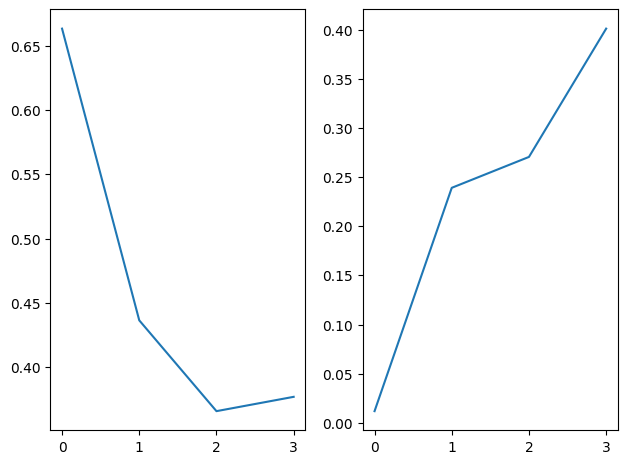

acc,▁▁▅▅▆▆██
afm,█▁▄▄█
avgp,▆█▁▂▄
bt,▁▆▇▇█
confOf-afm,▅▂▁▂█
confOf-avgp,▃▂▁▁█
confOf-bt,▁▆█▅▅
confOf-rec,█▁▁▅█
conference-afm,█▁▃▄▇
conference-avgp,█▁▃▃▅
conference-bt,▃▁█▃▆


In [13]:



def train_function(model, root_entities, graph_data, cq, cqid, res, caq, cqmask, tor):
    # accelerator = Accelerator(gradient_accumulation_steps=4)
    accelerator = Accelerator()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    lh = []
    evh = []
    epochs = 4
    batch_size = 2
    progress = None

    triplet_loss = nn.TripletMarginWithDistanceLoss(
        distance_function=lambda x, y: 1.0 - torch.cosine_similarity(x, y), margin=0.8)

    dataset = CQADataset(tokenizer, conts_cqa_subg, raw_data[test_ont], filter_bn=False)
    loader = DataLoader(dataset, batch_size=batch_size)

    cqloader = DataLoader(cqid, batch_size=batch_size, shuffle=False)
    acqloader = [DataLoader(a, batch_size=batch_size, shuffle=False) for a in caq]
    graph_loader = DataLoader(graph_data, batch_size=batch_size, shuffle=False)

    model, optimizer, loader, cqloader, graph_loader, *acqloader = accelerator.prepare(model, optimizer, loader,
                                                                                       cqloader, graph_loader,
                                                                                       *acqloader)

    model.find_unused_parameters = False
    if not progress and accelerator.is_main_process:
        progress = tqdm(total=epochs * len(loader))

    accelerator.print('First evaluation:')
    eval_test(accelerator, model, cqloader, graph_loader, cq, root_entities, res, acqloader, cqmask, tor)

    accelerator.print(f'ev data: {evm(accelerator, model, dataset, th=0.9):.2f}')

    for e in range(epochs):

        model.train()

        el = []
        for batch in loader:
            with accelerator.accumulate(model):
                optimizer.zero_grad()

                cqs, sbgs, nsbg = model(cqa=batch.cqs, positive_sbg=(batch.x_sf, batch.x_s,
                                                                     batch.edge_index_s, batch.edge_feat_sf,
                                                                     batch.edge_feat_s),
                                        negative_sbg=(batch.x_nf, batch.x_n,
                                                      batch.edge_index_n, batch.edge_feat_nf, batch.edge_feat_n))

                isbgs = sbgs[batch.rsi]
                isbgn = nsbg[batch.rni]

                loss = triplet_loss(cqs, isbgs, isbgn)
                el.append(accelerator.gather_for_metrics(loss.detach()))
                accelerator.backward(loss)

                optimizer.step()
                if accelerator.is_main_process:
                    progress.update(1)

        lh.append(torch.stack(el).mean().item())

        evh.append(evm(accelerator, model, dataset, th=0.9))
        eval_test(accelerator, model, cqloader, graph_loader, cq, root_entities, res, acqloader, cqmask, tor)
        accelerator.print(f'epoch {e} loss: {lh[-1]:.2f}, ev: {evh[-1]:.2f}')
        wandb.log({'acc': evh[-1], 'loss': lh[-1]})

    if accelerator.is_main_process:
        progress.close()

        fig, ax = plt.subplots(1, 2)
        fig.tight_layout()
        ax[0].plot(lh)
        ax[1].plot(evh)
        plt.show()

    if accelerator.is_main_process:
        wandb.finish()


model = Model()

notebook_launcher(train_function, (model, root_entities, graph_data, cq, cqid, fres, caq, cqmask, tor), num_processes=2,
                  use_port='29502')